In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ydata_profiling import ProfileReport # подробный разбор признаков
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer #модель для автозаполнения пустых ячеек
from sklearn.linear_model import LinearRegression
data_patch = '.\\'

In [3]:
transactions0 = pd.read_excel('transactions_data.xlsx')
transactions = transactions0.copy()
transactions.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena


In [4]:
clients_data0 = pd.read_json('clients_data.json')
clients_data = clients_data0.copy()
clients_data.head()

,id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,None,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


<div style="font-size: 30px">
1.Очистка и подготовка данных.

Проверим данные на пропущенные и аномальные значения

In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    9526 non-null   object 
 1   client_id         9798 non-null   object 
 2   transaction_date  10000 non-null  object 
 3   service           10000 non-null  object 
 4   amount            9540 non-null   float64
 5   payment_method    10000 non-null  object 
 6   city              10000 non-null  object 
 7   consultant        10000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


#Признак transaction_id не несёт в себе практического смысла и имеет достаточно много пропущенных значений. Удаляем его.

In [6]:
transactions.drop('transaction_id', axis=1, inplace=True)

#Признак client_id будет использоваться нами для соединения с датасетом clients_data. Поэтому, пока, отсутствующие строки удалим.

In [7]:
transactions.dropna(subset=['client_id'], inplace=True)

In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9798 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         9798 non-null   object 
 1   transaction_date  9798 non-null   object 
 2   service           9798 non-null   object 
 3   amount            9351 non-null   float64
 4   payment_method    9798 non-null   object 
 5   city              9798 non-null   object 
 6   consultant        9798 non-null   object 
dtypes: float64(1), object(6)
memory usage: 612.4+ KB


#Ознакомимся с составом признака transaction_date

In [9]:
transactions.transaction_date.info()

<class 'pandas.core.series.Series'>
Index: 9798 entries, 0 to 9999
Series name: transaction_date
Non-Null Count  Dtype 
--------------  ----- 
9798 non-null   object
dtypes: object(1)
memory usage: 153.1+ KB


In [10]:
transactions.transaction_date.head(100)

0      2025-01-04 00:02:20
1      2025-03-10 17:16:50
2      2025-02-13 19:43:49
4      2025-03-18 21:00:36
5      2025-02-21 21:50:30
              ...         
98            INVALID_DATE
99     2025-02-21 13:04:58
100    2025-03-12 10:26:06
101    2025-01-30 02:28:30
102    2025-02-14 13:42:25
Name: transaction_date, Length: 100, dtype: object

In [11]:
transactions['transaction_date'] = transactions['transaction_date'].astype(str)
transactions['is_valid'] = transactions['transaction_date'].str.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$')
transactions

,client_id,transaction_date,service,amount,payment_method,city,consultant,is_valid
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,True
1,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,True
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,True
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,True
5,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,2025-02-21 21:50:30,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,True
...,...,...,...,...,...,...,...,...
9995,b79d6e9f-75f6-4af9-8fdf-b42aac298a84,2025-01-14 05:07:17,Налоговое планирование,117114.096418,Неизвестно,South Thomas,John Wolfe,True
9996,d2a4a79b-26ba-41c9-b720-1362b9f464f0,INVALID_DATE,Финансовое планирование,19895.571828,Кредитная карта,Davidsonborough,Ronald Shepherd,False
9997,5e1d67fb-26ea-48cc-9e2d-e2edbda404d0,2025-02-09 17:33:42,Неизвестная услуга,79279.034410,Банковский перевод,Lake Arielmouth,Mary Howard,True
9998,77ea6e72-df3c-47d4-a043-f990cc05a6f4,2025-01-21 03:54:39,Инвестиционное консультирование,26365.015457,Криптовалюта,Tonystad,David Palmer,True


In [12]:
transactions['is_valid'].value_counts()

is_valid
True     8813
False     985
Name: count, dtype: int64

In [13]:
invalid_rows = transactions[transactions['is_valid'] == False]
invalid_rows.transaction_date.value_counts()

transaction_date
INVALID_DATE    985
Name: count, dtype: int64

#Из признака transaction_date сделаем признаки с годом, месяцем, днем недели, днем и временем дня(утро, день, вечер, ночь)

In [14]:
#Для этого конвертируем в формат даты, игнорируя недействительные даты
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'], errors='coerce')

In [15]:
#Извлекаем компоненты, заполнив NaN для недействительных дат
transactions['year'] = transactions['transaction_date'].dt.year
transactions['month'] = transactions['transaction_date'].dt.month
transactions['day'] = transactions['transaction_date'].dt.day
transactions['day_of_week'] = transactions['transaction_date'].dt.dayofweek
transactions['hour'] = transactions['transaction_date'].dt.hour

In [16]:
#Напишем функцию для разбития часов на отрезки по времени суток
def get_time_of_day(hour):
    if pd.isna(hour):  # Проверка на NaN
        return np.nan
    elif 6 <= hour < 10:
        return 1 #'Утро'
    elif 10 <= hour < 17:
        return 2 #'День'
    elif 17 <= hour < 22:
        return 3 #'Вечер'
    else:
        return 4 #'Ночь'

# Примененим функцию с учетом NaN
transactions['time_of_day'] = transactions['transaction_date'].dt.hour.apply(get_time_of_day)
transactions.drop('transaction_date', axis=1, inplace=True)

In [17]:
transactions.head()

,client_id,service,amount,payment_method,city,consultant,is_valid,year,month,day,day_of_week,hour,time_of_day
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller,True,2025.0,1.0,4.0,5.0,0.0,4.0
1,c940f45c-d29b-439a-8fa3-f75018cef528,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard,True,2025.0,3.0,10.0,0.0,17.0,3.0
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer,True,2025.0,2.0,13.0,3.0,19.0,3.0
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena,True,2025.0,3.0,18.0,1.0,21.0,3.0
5,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,Инвестиционное консультирование,85575.773285,Кредитная карта,West Jaymouth,Harold Gibson,True,2025.0,2.0,21.0,4.0,21.0,3.0


In [18]:
transactions.year.value_counts()

year
2025.0    8813
Name: count, dtype: int64

#Так как год одинаковый- удалим признак

In [19]:
transactions.drop('year', axis=1, inplace=True)

#Так как сумма очень важна и пропущенных значений всего 4,6%, удалим пропущенные значения

In [20]:
transactions.dropna(subset=['amount'], inplace=True, ignore_index=True)

In [21]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       9351 non-null   object 
 1   service         9351 non-null   object 
 2   amount          9351 non-null   float64
 3   payment_method  9351 non-null   object 
 4   city            9351 non-null   object 
 5   consultant      9351 non-null   object 
 6   is_valid        9351 non-null   bool   
 7   month           8411 non-null   float64
 8   day             8411 non-null   float64
 9   day_of_week     8411 non-null   float64
 10  hour            8411 non-null   float64
 11  time_of_day     8411 non-null   float64
dtypes: bool(1), float64(6), object(5)
memory usage: 812.9+ KB


#Применим регрессионную модель для заполнения пустых значений

In [22]:
df_no_imputed = transactions[['amount', 'month', 'day', 'day_of_week', 'hour', 'time_of_day']]
imputer = IterativeImputer(random_state=2)

df_imputed = imputer.fit_transform(df_no_imputed)

df_imputed = pd.DataFrame(df_imputed, columns=df_no_imputed.columns)

#Округляем полученные значения

In [23]:
df_imputed[['month', 'day', 'day_of_week', 'hour', 'time_of_day']] = df_imputed[['month', 'day', 'day_of_week', 'hour', 'time_of_day']].round()
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount       9351 non-null   float64
 1   month        9351 non-null   float64
 2   day          9351 non-null   float64
 3   day_of_week  9351 non-null   float64
 4   hour         9351 non-null   float64
 5   time_of_day  9351 non-null   float64
dtypes: float64(6)
memory usage: 438.5 KB


#Заменим данные на данные после применения модели

In [24]:
transactions.drop(['amount', 'month', 'day', 'day_of_week', 'hour', 'time_of_day', 'is_valid'], axis=1, inplace=True)
transactions = transactions.join(df_imputed, how='outer')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       9351 non-null   object 
 1   service         9351 non-null   object 
 2   payment_method  9351 non-null   object 
 3   city            9351 non-null   object 
 4   consultant      9351 non-null   object 
 5   amount          9351 non-null   float64
 6   month           9351 non-null   float64
 7   day             9351 non-null   float64
 8   day_of_week     9351 non-null   float64
 9   hour            9351 non-null   float64
 10  time_of_day     9351 non-null   float64
dtypes: float64(6), object(5)
memory usage: 803.7+ KB


In [25]:
transactions.head()

,client_id,service,payment_method,city,consultant,amount,month,day,day_of_week,hour,time_of_day
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,Структурирование капитала,Банковский перевод,North Patrickport,Cheryl Waller,55838.059789,1.0,4.0,5.0,0.0,4.0
1,c940f45c-d29b-439a-8fa3-f75018cef528,Структурирование капитала,Неизвестно,New Zacharyport,Frank Pollard,37514.809209,3.0,10.0,0.0,17.0,3.0
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,Структурирование капитала,Неизвестно,Port Michellemouth,Alexandra Meyer,21022.146872,2.0,13.0,3.0,19.0,3.0
3,3f43d7bc-37f0-4535-8391-51702d6ff81e,Структурирование капитала,Неизвестно,Bondstad,Melissa Pena,5636.586955,3.0,18.0,1.0,21.0,3.0
4,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,Инвестиционное консультирование,Кредитная карта,West Jaymouth,Harold Gibson,85575.773285,2.0,21.0,4.0,21.0,3.0


In [26]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       9351 non-null   object 
 1   service         9351 non-null   object 
 2   payment_method  9351 non-null   object 
 3   city            9351 non-null   object 
 4   consultant      9351 non-null   object 
 5   amount          9351 non-null   float64
 6   month           9351 non-null   float64
 7   day             9351 non-null   float64
 8   day_of_week     9351 non-null   float64
 9   hour            9351 non-null   float64
 10  time_of_day     9351 non-null   float64
dtypes: float64(6), object(5)
memory usage: 803.7+ KB


<div style="font-size: 30px">
2.Анализ данных.

#Определить топ-5 наиболее популярных услуг по количеству заказов

In [27]:
top_services = transactions.service.value_counts().head(5)

for service, count in top_services.items():
    print(f"{service}: {count}")

Инвестиционное консультирование: 2279
Управление активами: 1881
Финансовое планирование: 1425
Налоговое планирование: 1423
Структурирование капитала: 1407


#Рассчитать среднюю сумму транзакций по каждому городу.

In [28]:
average_transaction_by_city = transactions.groupby('city')['amount'].mean().round(2)

print(average_transaction_by_city)

city
Aprilstad             49701.97
Bondstad              51417.72
Cruzport              45913.87
Dannyburgh            48039.48
Davidmouth            47039.27
Davidsonborough       50132.15
East Jamie            42909.90
East Matthewmouth     49293.21
East Melissaville     49909.35
East Rachelmouth      54206.20
Elizabethmouth        44447.63
Erichaven             50927.91
Hamiltontown          48663.06
Harrisberg            50595.13
Ibarramouth           44376.42
Jeanettetown          44298.50
Johnsonfort           52111.94
Kaneburgh             52495.64
Karenville            48719.38
Krystalland           50586.40
Lake Arielmouth       50955.63
Lake Sallychester     46811.91
Lake Tina             51491.78
Matthewsville         44828.01
Mayoberg              48970.53
Michellehaven         55729.81
Mirandaside           44878.13
New Chelseaberg       47272.03
New Dianechester      46200.48
New Ryan              45908.23
New Tommyborough      53662.09
New Zacharyport       52728.03
Nor

#Определить услугу с наибольшей выручкой (по сумме amount).

In [31]:
revenue_by_service = transactions.groupby('service')['amount'].sum()
top_service = revenue_by_service.idxmax()  # Название услуги
top_service_revenue = revenue_by_service.max().round(2)  # Сумма выручки

print(f"Услуга с наибольшей выручкой: {top_service} с выручкой {top_service_revenue}")


Услуга с наибольшей выручкой: Инвестиционное консультирование с выручкой 113071063.45


#Вычислить процент транзакций по способам оплаты (наличные, банковский перевод и т. д.).

In [40]:
total_transactions = transactions.shape[0]
payment_method_counts = transactions['payment_method'].value_counts()

payment_method_percentage = ((payment_method_counts / total_transactions) * 100)

print("Процент транзакций по способам оплаты:")
print(payment_method_percentage)

Процент транзакций по способам оплаты:
payment_method
Кредитная карта       40.102663
Банковский перевод    34.488290
Неизвестно            10.041707
Наличные               9.934766
Криптовалюта           5.432574
Name: count, dtype: float64


In [37]:
payment_method_percentage.sum()

100.0

#Рассчитать выручку за последний месяц (по сумме amount).

In [39]:
last_month = transactions['month'].max()

last_month_revenue = transactions[(transactions['month'] == last_month)]['amount'].sum().round(2)

print(f"Выручка за последний месяц: {last_month_revenue}")

Выручка за последний месяц: 103549291.24


<div style="font-size: 30px">
3.Объединение данных.

#Объединить транзакции с клиентскими данными (по id)

In [41]:
clients_data.head()

,id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,None,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


#Ознакомимся с данными датасета клиентов и удалим строки с отсутствующим id

In [44]:
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9799 entries, 0 to 9798
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         9798 non-null   object 
 1   age        8816 non-null   float64
 2   gender     6480 non-null   object 
 3   net_worth  9324 non-null   float64
dtypes: float64(2), object(2)
memory usage: 306.3+ KB


In [46]:
clients_data.dropna(subset=['id'], inplace=True, ignore_index=True)
clients_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9798 entries, 0 to 9797
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         9798 non-null   object 
 1   age        8815 non-null   float64
 2   gender     6479 non-null   object 
 3   net_worth  9323 non-null   float64
dtypes: float64(2), object(2)
memory usage: 306.3+ KB


In [49]:
transactions = transactions.join(clients_data.set_index('id'), on='client_id', how='left')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       9351 non-null   object 
 1   service         9351 non-null   object 
 2   payment_method  9351 non-null   object 
 3   city            9351 non-null   object 
 4   consultant      9351 non-null   object 
 5   amount          9351 non-null   float64
 6   month           9351 non-null   float64
 7   day             9351 non-null   float64
 8   day_of_week     9351 non-null   float64
 9   hour            9351 non-null   float64
 10  time_of_day     9351 non-null   float64
 11  age             8404 non-null   float64
 12  gender          6177 non-null   object 
 13  net_worth       8895 non-null   float64
dtypes: float64(8), object(6)
memory usage: 1022.9+ KB


In [53]:
transactions.gender.value_counts()

gender
Женщина    3127
Мужчина    3050
Name: count, dtype: int64

In [55]:
list_gender = transactions.gender.value_counts().index
transactions.gender = transactions.gender.map({list_gender[0]: 0, list_gender[1]: 1})
transactions.gender.value_counts()

gender
0.0    3127
1.0    3050
Name: count, dtype: int64

#Применим регрессионную модель для заполнения пустых значений

In [58]:
df_no_imputed = transactions[['amount', 'month', 'day', 'day_of_week', 'hour', 'time_of_day', 'age', 'gender', 'net_worth']]
imputer = IterativeImputer(random_state=2)

df_imputed = imputer.fit_transform(df_no_imputed)

df_imputed = pd.DataFrame(df_imputed, columns=df_no_imputed.columns)

#Округляем полученные значения
df_imputed[['age', 'gender', 'net_worth']] = df_imputed[['age', 'gender', 'net_worth']].round()
df_imputed.info()

#Заменим данные на данные после применения модели
transactions.drop(['amount', 'month', 'day', 'day_of_week', 'hour', 'time_of_day', 'age', 'gender', 'net_worth'], axis=1, inplace=True)
transactions = transactions.join(df_imputed, how='outer')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount       9351 non-null   float64
 1   month        9351 non-null   float64
 2   day          9351 non-null   float64
 3   day_of_week  9351 non-null   float64
 4   hour         9351 non-null   float64
 5   time_of_day  9351 non-null   float64
 6   age          9351 non-null   float64
 7   gender       9351 non-null   float64
 8   net_worth    9351 non-null   float64
dtypes: float64(9)
memory usage: 657.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351 entries, 0 to 9350
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       9351 non-null   object 
 1   service         9351 non-null   object 
 2   payment_method  9351 non-null   object 
 3   city            9351 non-null   object 
 4   consulta

In [59]:
transactions.head()

,client_id,service,payment_method,city,consultant,amount,month,day,day_of_week,hour,time_of_day,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,Структурирование капитала,Банковский перевод,North Patrickport,Cheryl Waller,55838.059789,1.0,4.0,5.0,0.0,4.0,41.0,1.0,2514729.0
1,c940f45c-d29b-439a-8fa3-f75018cef528,Структурирование капитала,Неизвестно,New Zacharyport,Frank Pollard,37514.809209,3.0,10.0,0.0,17.0,3.0,28.0,1.0,566568.0
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,Структурирование капитала,Неизвестно,Port Michellemouth,Alexandra Meyer,21022.146872,2.0,13.0,3.0,19.0,3.0,55.0,0.0,1896001.0
3,3f43d7bc-37f0-4535-8391-51702d6ff81e,Структурирование капитала,Неизвестно,Bondstad,Melissa Pena,5636.586955,3.0,18.0,1.0,21.0,3.0,31.0,1.0,4865850.0
4,900f7d6b-ee7f-49e6-ae9f-e5ea9e04ab4c,Инвестиционное консультирование,Кредитная карта,West Jaymouth,Harold Gibson,85575.773285,2.0,21.0,4.0,21.0,3.0,59.0,0.0,3992282.0


#Создать новую колонку с уровнями активов.

In [64]:
#Напишем функцию для разбития часов на отрезки по времени суток
def asset(worth):
    if worth < 100000:
        return 'Низкий капитал'
    elif 100000 <= worth <= 1000000:
        return 'Средний капитал'
    else:
        return 'Высокий капитал'

transactions['asset_level'] = transactions['net_worth'].apply(asset)
transactions['asset_level'].value_counts()

asset_level
Высокий капитал    7637
Средний капитал    1548
Низкий капитал      166
Name: count, dtype: int64

#Провести анализ по уровням активов и определить, какие категории клиентов приносят наибольшую выручку.

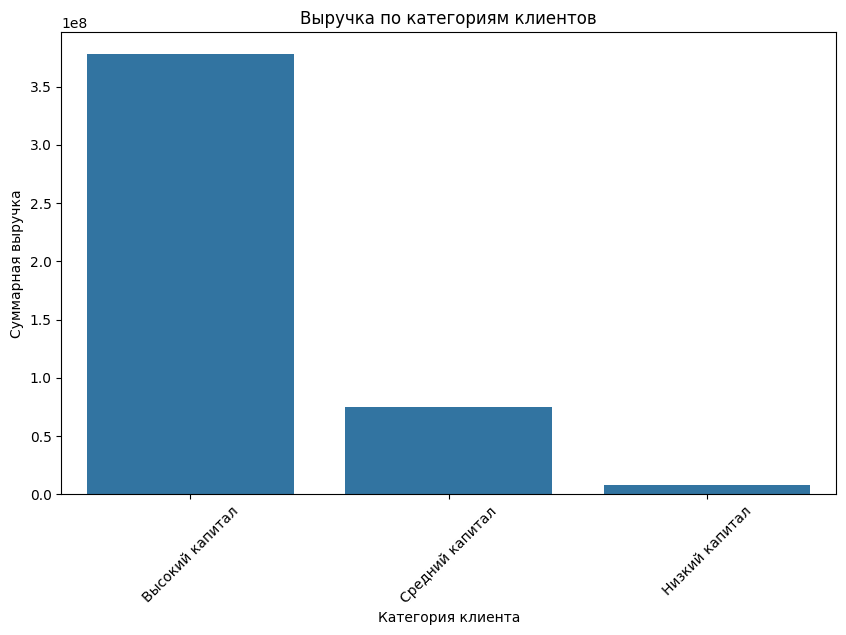

In [67]:
revenue_by_category = transactions.groupby('asset_level')['amount'].sum().reset_index()

revenue_by_category = revenue_by_category.sort_values(by='amount', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=revenue_by_category, x='asset_level', y='amount')
plt.title('Выручка по категориям клиентов')
plt.xlabel('Категория клиента')
plt.ylabel('Суммарная выручка')
plt.xticks(rotation=45)
plt.show()

#По итогам анализа ясно, что наибольшую прибыль приносят клиенты с высоким капиталом

<div style="font-size: 30px">
4.Визуализация данных (* дополнительное задание).

#Построить распределение сумм транзакций.

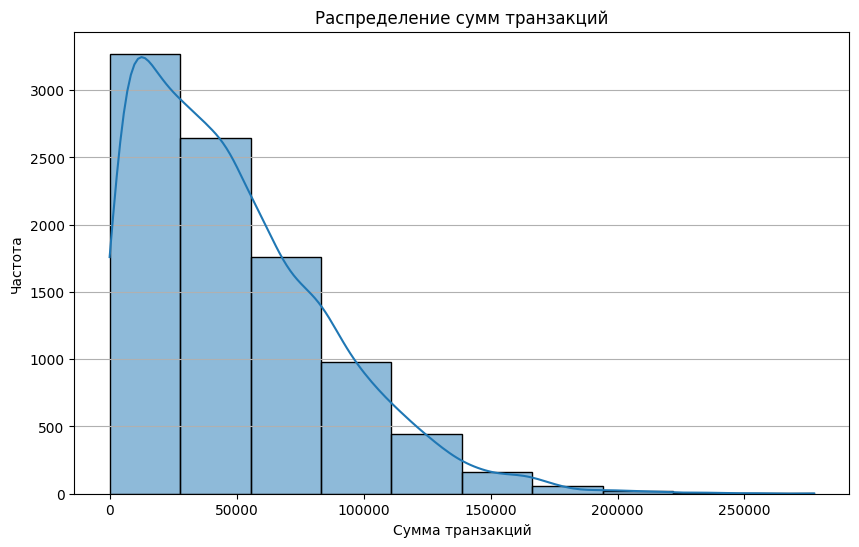

In [69]:
plt.figure(figsize=(10, 6))

sns.histplot(transactions['amount'], bins=10, kde=True)
plt.title('Распределение сумм транзакций')
plt.xlabel('Сумма транзакций')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.show()

#Создать диаграмму выручки по услугам.

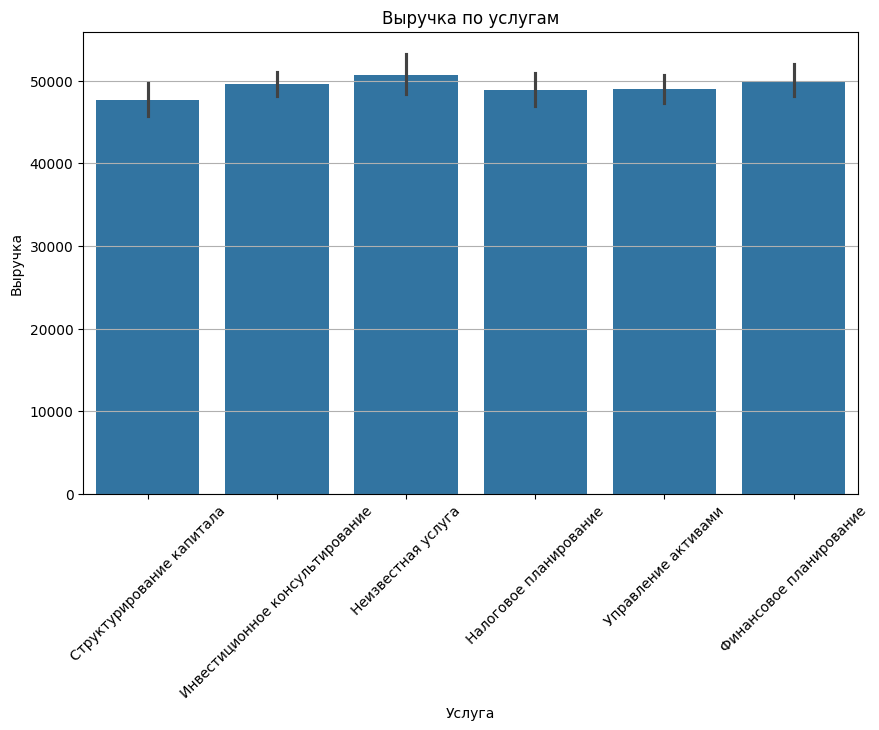

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=transactions, x='service', y='amount')

plt.title('Выручка по услугам')
plt.xlabel('Услуга')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#Построить график зависимости средней суммы транзакции от возраста клиентов.

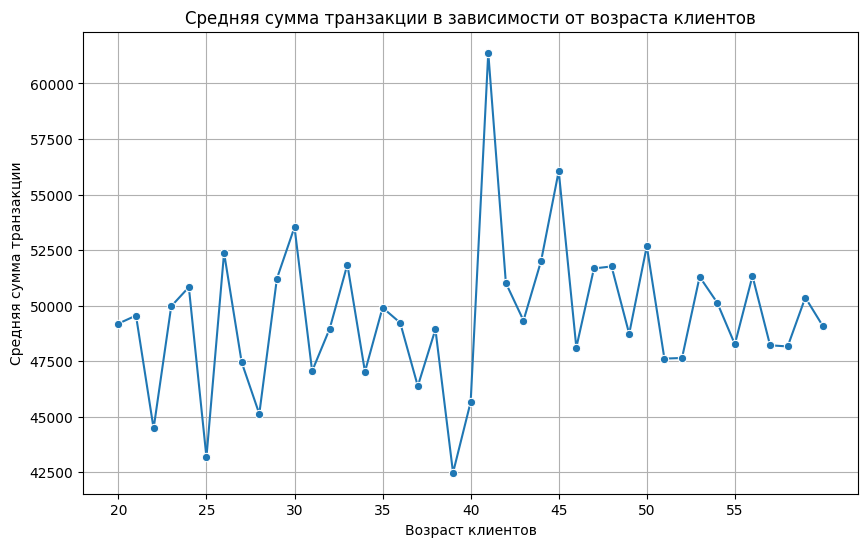

In [72]:
average_transaction = transactions.groupby('age')['amount'].mean().reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_transaction, x='age', y='amount', marker='o')

plt.title('Средняя сумма транзакции в зависимости от возраста клиентов')
plt.xlabel('Возраст клиентов')
plt.ylabel('Средняя сумма транзакции')
plt.grid()
plt.xticks(range(20, 60, 5))
plt.show()

<div style="font-size: 30px">
5.Прогнозирование (* дополнительное задание).

#Прогнозирование спроса на следующий месяц (например, с использованием линейной регрессии).

Прогнозируемый спрос на следующий месяц: 89615210.89


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


([<matplotlib.axis.XTick at 0x1a8458fb110>,
 [Text(1.0, 0, '1'), Text(2.0, 0, '2'), Text(3.0, 0, '3')])

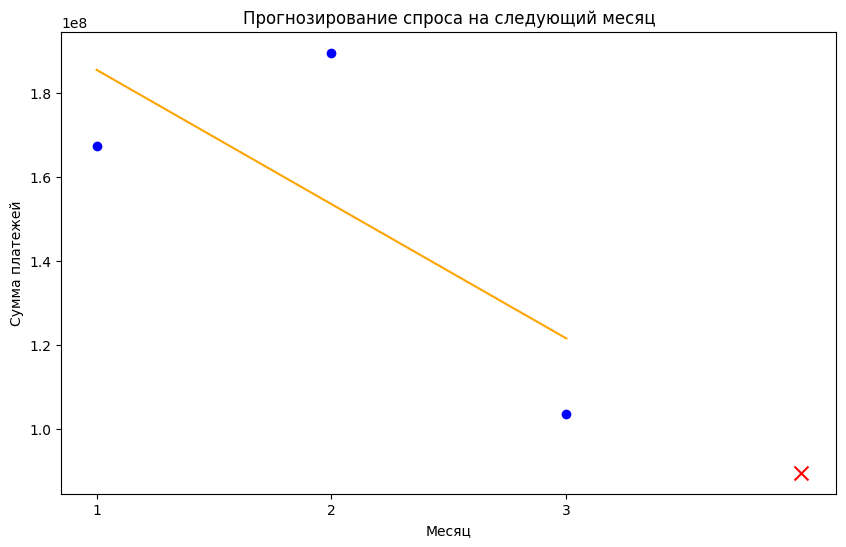

In [81]:
monthly_demand = transactions.groupby('month')['amount'].sum().reset_index()

X = monthly_demand[['month']]
y = monthly_demand['amount']

model = LinearRegression()
model.fit(X, y)

next_month = np.array([[4]])
predicted_demand = model.predict(next_month)

print(f'Прогнозируемый спрос на следующий месяц: {predicted_demand[0].round(2)}')

plt.figure(figsize=(10, 6))
plt.scatter(monthly_demand['month'], monthly_demand['amount'], color='blue', label='Фактический спрос')
plt.plot(monthly_demand['month'], model.predict(X), color='orange')
plt.scatter(next_month, predicted_demand, color='red', label='Прогноз на следующий месяц', marker='x', s=100)
plt.title('Прогнозирование спроса на следующий месяц')
plt.xlabel('Месяц')
plt.ylabel('Сумма платежей')
plt.xticks(monthly_demand['month'])